In [7]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import matplotlib.ticker as mticker
import pandas as pd
import datetime
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as pltcolors

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

import matplotlib.path as mpath

In [29]:
2000*px

27.777777777777775

Plotting 2023-01-26T02:00
Plotting precipitation.
Plotting MSLP.
Plotting temp.
Saving.


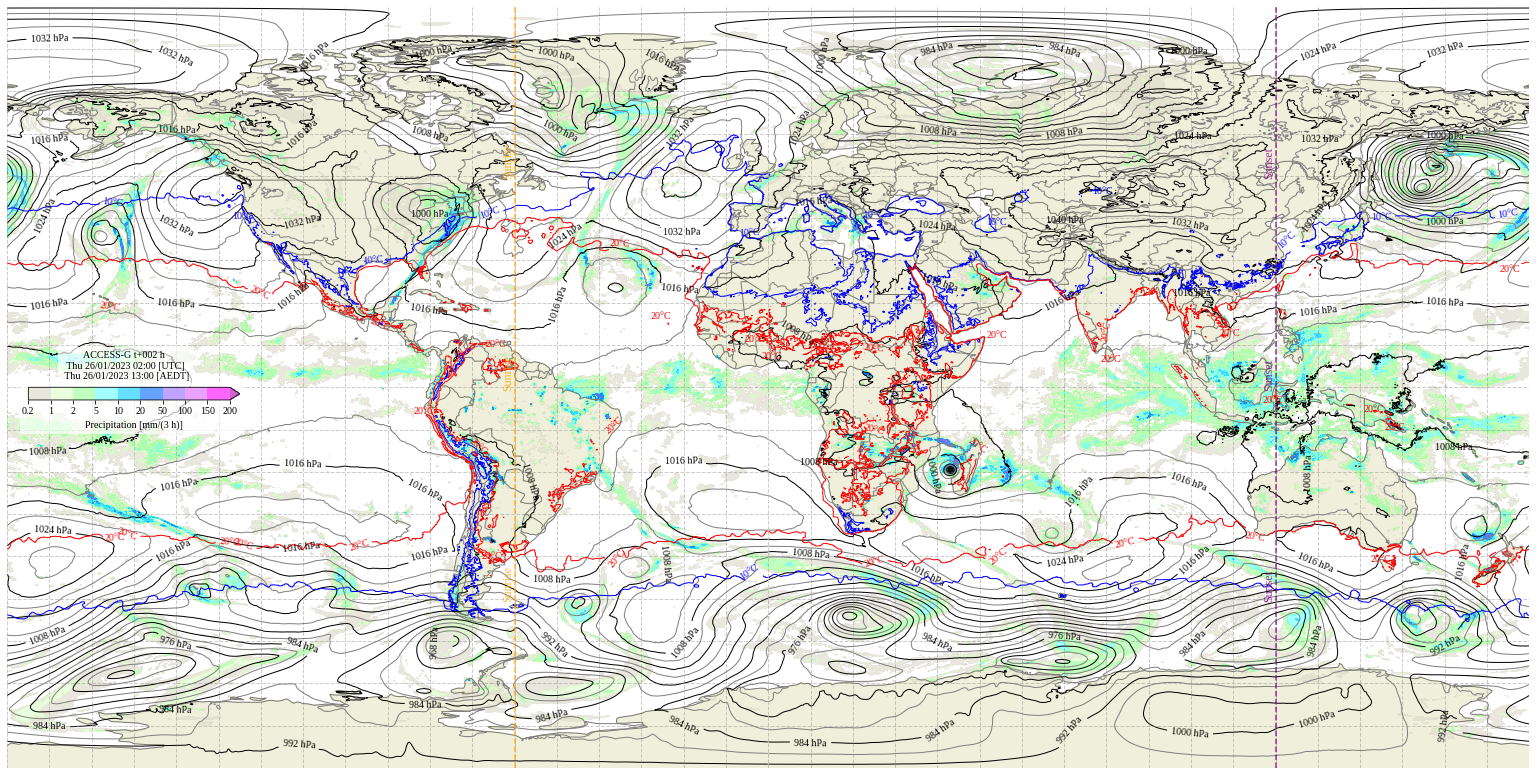

In [32]:
base_path = 'https://dapds00.nci.org.au/thredds/dodsC/wr45/ops_aps3/access-g/1/20230126/0000/fc/sfc/'

field = 'mslp'
mslp = xr.open_dataset(base_path + field + '.nc')[field]

field = 'accum_prcp'
prcp = xr.open_dataset(base_path + field + '.nc')[field]

field = 'sfc_temp'
temp = xr.open_dataset(base_path + field + '.nc')[field]

lab_pos = []
for i in np.arange(-170, 190, 30):
    lab_pos += list(zip(
        np.ones(8)*i, 
        np.array([-80, -60, -40, -20, 20, 40, 60, 80])))
    
temp_lab_pos = []    
for i in np.arange(-170+15, 190+15, 30):
    temp_lab_pos += list(zip(
        np.ones(4)*i, 
        np.array([-40, -10, 10, 40])))

# Omni Globe
lvls = np.array([0.2, 1, 2, 5, 10, 20, 50, 100, 150, 200])
colors = np.array([
    [219, 216, 199], [220, 255, 200], [150, 255, 150], [100, 255, 255],
    [0, 200, 255], [0, 100, 255], [150, 100, 255], [220, 100, 255],
    [255, 0, 255], [255*2/3, 0, 255*2/3]])/255

mslp_lab_lvls = np.arange(840, 1120, 8)
mslp_fmt = {p: '{} hPa'.format(p) for p in mslp_lab_lvls}

t1 = 10
t2 = 20

temp_fmt = {
    t1: u'{}\u00B0C'.format(t1), 
    t2: u'{}\u00B0C'.format(t2)}

for i in np.arange(len(mslp.time.values))[1:2]:
# for i in [0]:
    time = mslp.time.values[i]
    print('Plotting {}'.format(
        np.datetime_as_string(time, unit='m')))
    plt.close('all')

    proj = ccrs.PlateCarree()
    
    rcParams.update({'font.family': 'serif'})
    rcParams.update({'font.serif': 'Liberation Serif'})
    rcParams.update({'mathtext.fontset': 'dejavuserif'})
    rcParams.update({'font.size': 10})

    px = 1/rcParams['figure.dpi']
    
    fig = plt.figure(figsize=(28, 14))
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Setup Map
    grid = ax.gridlines(
        crs=proj, draw_labels=True,
        linewidth=1, color='gray', alpha=0.4, linestyle='--')
    
    grid.right_labels = False
    grid.top_labels = False
    grid.left_labels = False
    grid.bottom_labels = False

    grid.xlocator = mticker.FixedLocator(np.arange(-180, 180+10, 10))
    grid.ylocator = mticker.FixedLocator(np.arange(-90, 100, 10))

    ax.add_feature(cfeature.LAND)
    ax.add_feature(
        cfeature.COASTLINE, linewidth=1, 
        edgecolor=np.array([0.9375  , 0.9375  , 0.859375])/2)
    ax.add_feature(
        cfeature.BORDERS, 
        edgecolor=np.array([0.9375  , 0.9375  , 0.859375])/2, 
        linewidth=1)
    
    # Plot datasets
    hour = int(np.datetime_as_string(time, unit='m')[-5:-3])
    
    sunrise_lon = 360*np.mod((hour-6), 24)/24
    sunset_lon = 360*np.mod((hour-18), 24)/24
    
    if sunrise_lon > 180:
        sunrise_lon -= 360
    if sunset_lon > 180:
        sunset_lon -= 360
        
    mslp_i = mslp.sel(time=time)
    
    prcp_i = (prcp.isel(time=i)-prcp.isel(time=(i-1)))
    prcp_i = 3*prcp_i/997*1e3
    
    temp_i = temp.sel(time=time) - 273.15
    
    print('Plotting precipitation.')
        
    conp = ax.contourf(
        prcp_i.lon, prcp_i.lat, prcp_i, levels=lvls, 
        extend='max', colors=colors[:-1], alpha=.6)
    conp.cmap.set_over(colors[-1])
    conp.changed()
    
    # Setup colorbar
    cbbox = ax.inset_axes([-177, -11, 53, 12], transform=ax.transData)
    cbbox.set_facecolor([1,1,1,.7])
    [cbbox.spines[k].set_visible(False) for k in cbbox.spines]
    cbbox.axes.get_xaxis().set_visible(False)
    cbbox.axes.get_yaxis().set_visible(False)
    cbbox.set_xticklabels([])
    cbbox.set_xticks([])
    cbbox.set_yticklabels([])
    cbbox.set_yticks([])

    axin = ax.inset_axes([-175, -3, 50, 3], transform=ax.transData)
    cbar = plt.colorbar(
        conp, orientation='horizontal', ax=ax, cax=axin)
    cbar.ax.set_xticklabels(
        ['0.2', '1', '2', '5', '10', '20', '50', '100', '150', '200'])
    cbar.ax.set_xlabel('Precipitation [mm/(3 h)]')

    print('Plotting MSLP.')        

    con4 = ax.contour(
        mslp_i.lon, mslp_i.lat, mslp_i/1e2, 
        levels=np.arange(844, 1104, 8), colors='grey',
        linewidths=1)
    
    con8 = ax.contour(
        mslp_i.lon, mslp_i.lat, mslp_i/1e2, 
        levels=np.arange(840, 1120, 8), colors='k',
        linewidths=1)
    
    ax.clabel(
        con8, inline=True, fontsize=10, manual=lab_pos, fmt=mslp_fmt)
    
    print('Plotting temp.')
    
    cont = ax.contour(
        temp_i.lon, temp_i.lat, temp_i, 
        levels=np.array([t1, t2]), colors=['blue', 'red'],
        linewidths=1, linestyles='solid')
    
    ax.clabel(
        cont, inline=True, fontsize=10, manual=temp_lab_pos, fmt=temp_fmt)
    
    for lt in [-50, 0, 50]:
        ax.text(
            sunrise_lon-3, lt, 'Sunrise', rotation='vertical', color='orange',
            fontsize=12, alpha=.8)
        ax.text(
            sunset_lon-3, lt, 'Sunset', rotation='vertical', color='purple',
            fontsize=12, alpha=.8)

    sr = ax.plot(
        [sunrise_lon, sunrise_lon], 
        [-90, 90], '--', color='orange', alpha=.8)
    ss = ax.plot(
        [sunset_lon, sunset_lon], 
        [-90, 90], '--', alpha=.8, color='purple')
    
    # Get local melbourne time - with daylight savings calculated!
    first_sunday_oct = np.busday_offset(
        str(time)[:5] + '10', 0, roll='forward', weekmask='Sun')
    first_sunday_apr = np.busday_offset(
        str(time)[:5] + '04', 0, roll='forward', weekmask='Sun')
    
    time_dt = pd.to_datetime(str(time))
    time_str = (
        time_dt.day_name()[:3] + ' ' + time_dt.strftime('%d/%m/%Y %H:%M'))
    
    if (
            time < (first_sunday_apr + np.timedelta64(2, 'h')) 
            or time >= (first_sunday_oct + np.timedelta64(2, 'h'))):
        mel_tz = 'AEDT'
        mel_time = time + np.timedelta64(11, 'h')
    else:
        mel_tz = 'AEST'
        mel_time = time + np.timedelta64(10, 'h')
    
#     import pdb; pdb.set_trace()
        
    mel_time_dt = pd.to_datetime(str(mel_time))
    mel_time_str = (
        mel_time_dt.day_name()[:3] + ' ' 
        + mel_time_dt.strftime('%d/%m/%Y %H:%M'))

    label = 'ACCESS-G t+{:03d} h \n {} [UTC] \n {} [{}]'.format(
        i+1, time_str, mel_time_str, mel_tz)
       
    ax.text(
        -152, 2, label, ha='center', fontsize=10, 
        backgroundcolor=[1, 1, 1, .7])
    
    ax.axis('off')
    
    print('Saving.')
    plt.savefig(
        './mslp_{:04d}.png'.format(i), bbox_inches='tight', 
        facecolor='w', pad_inches=0, dpi=190)

In [10]:
# proj = ccrs.SouthPolarStereo()

Saving.


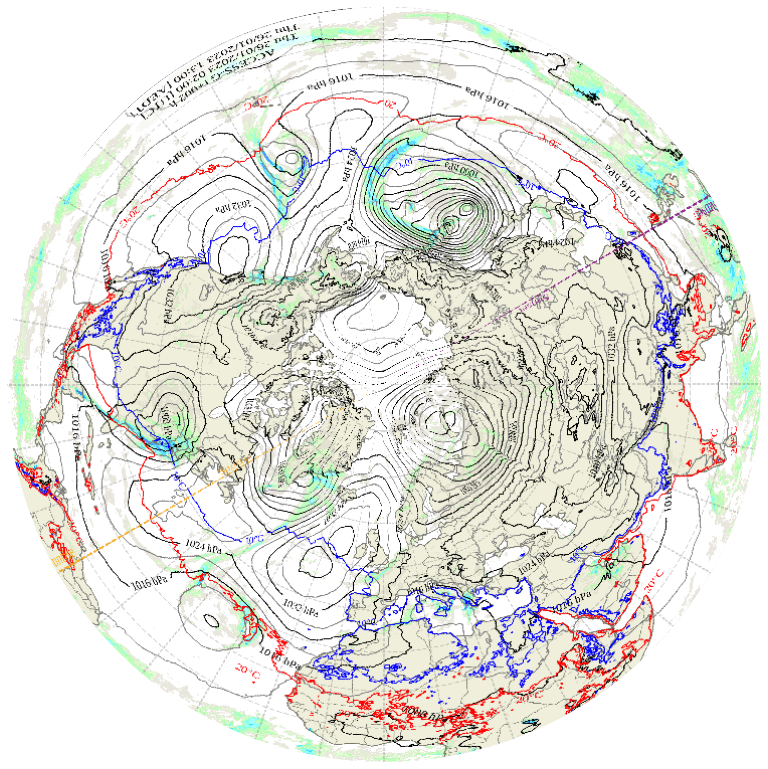

In [8]:
# import pdb; pdb.set_trace()
proj = ccrs.LambertAzimuthalEqualArea(central_latitude=90)
px = 1/rcParams['figure.dpi']

fig = plt.figure(figsize=(1000*px, 1000*px))
ax = fig.add_subplot(1, 1, 1, projection=proj)

img_extent = (-180, 180, -90, 90)
img = plt.imread('mslp_0001.png')

ax.imshow(
    img, origin='upper', extent=img_extent, 
    transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

print('Saving.')
ax.set_boundary(circle, transform=ax.transAxes)
ax.imshow(
    img, origin='upper', extent=img_extent, 
    transform=ccrs.PlateCarree())
ax.axis('off')

plt.savefig(
    'test1.png', bbox_inches='tight', 
    facecolor='k', pad_inches=0, dpi=190)

In [9]:
px

0.013888888888888888

Saving.


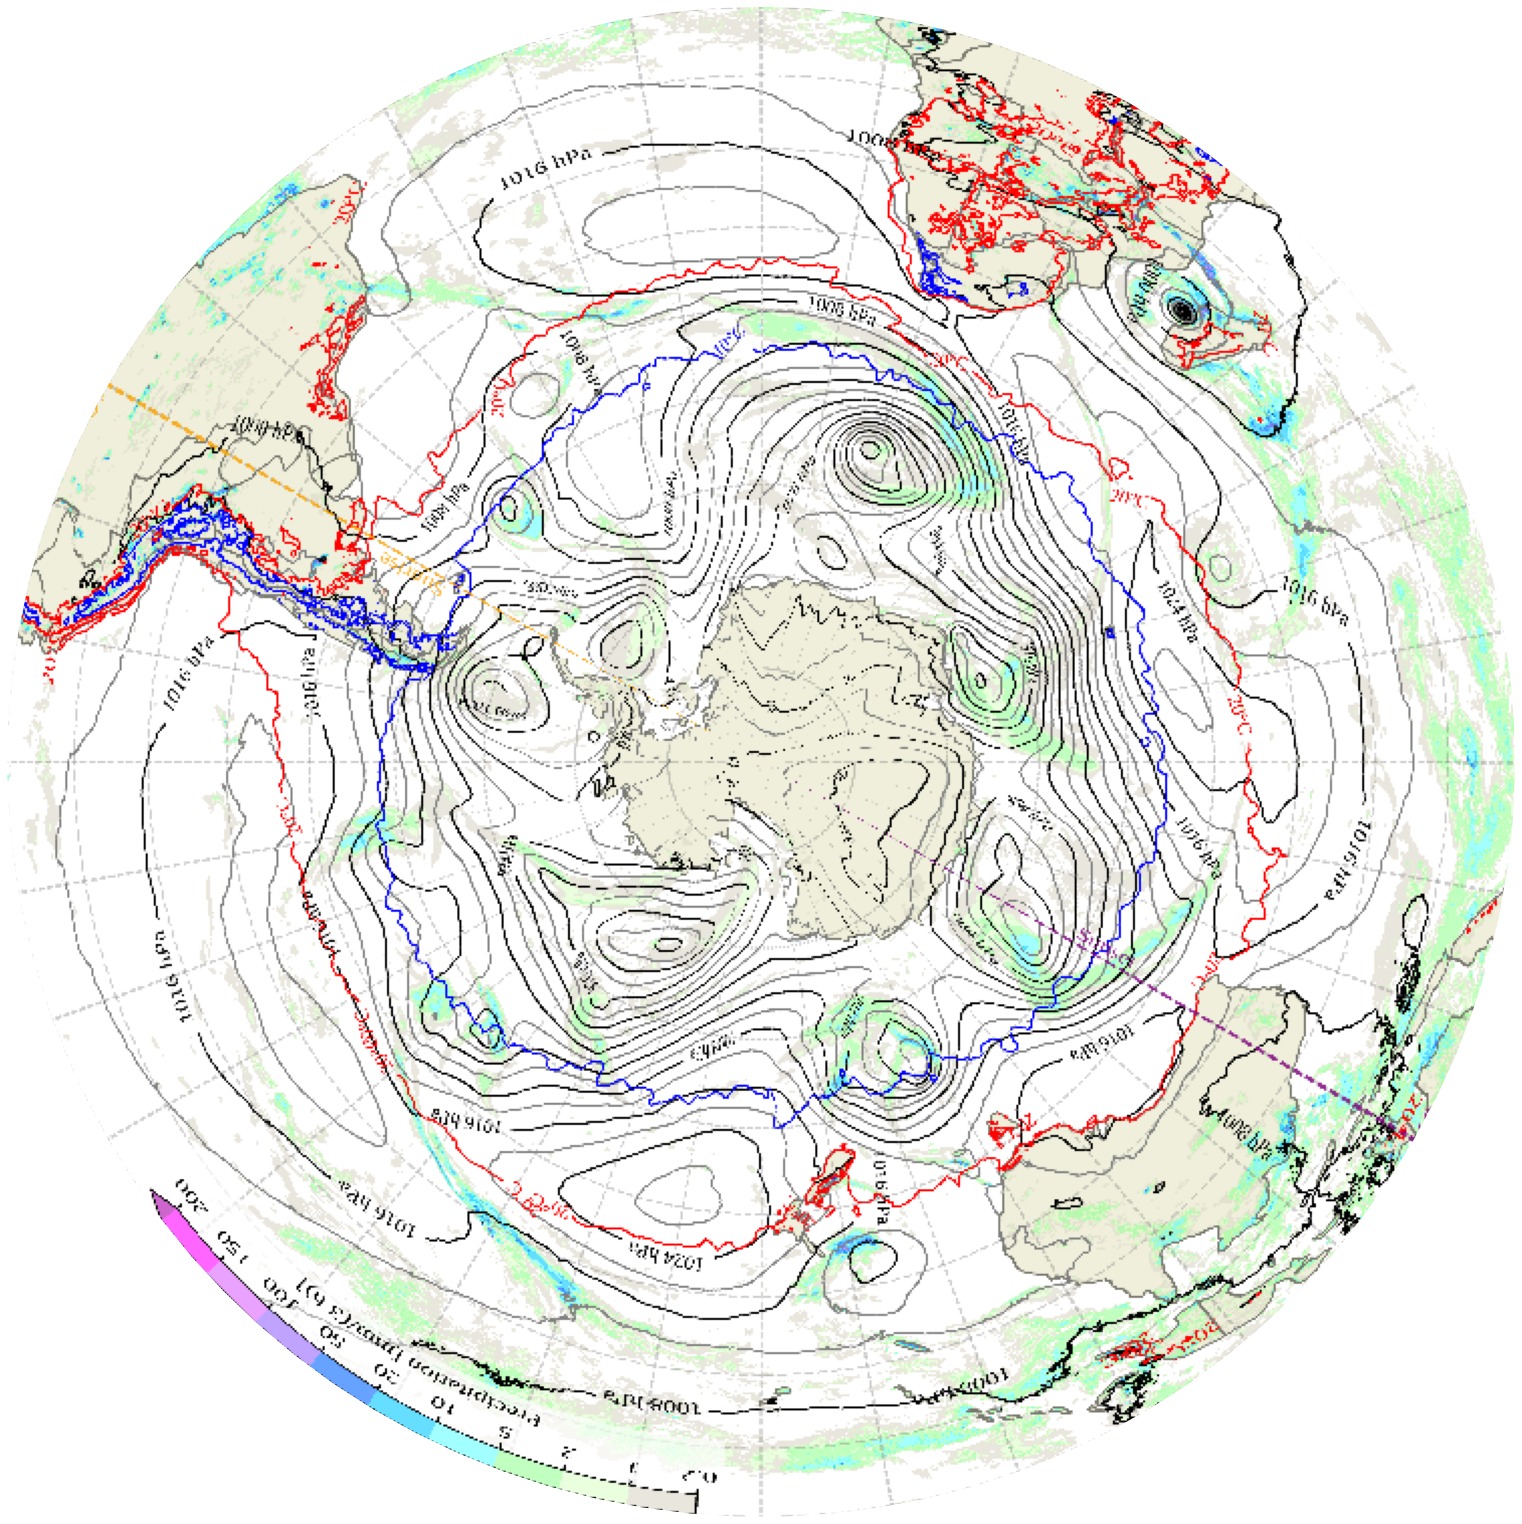

In [12]:
proj = ccrs.LambertAzimuthalEqualArea(central_latitude=-90, central_longitude=0)

fig = plt.figure(figsize=(2000*px, 2000*px))
ax = fig.add_subplot(1, 1, 1, projection=proj)

img_extent = (-180, 180, -90, 90)
img = plt.imread('mslp_0001.png')

ax.imshow(
    img, origin='upper', extent=img_extent, 
    transform=ccrs.PlateCarree(), regrid_shape=2000)
ax.set_extent([-180, 180, -90, 0], crs=ccrs.PlateCarree())

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

print('Saving.')
ax.set_boundary(circle, transform=ax.transAxes)
ax.imshow(
    img, origin='upper', extent=img_extent, 
    transform=ccrs.PlateCarree())
ax.axis('off')

plt.savefig(
    'test2.png', bbox_inches='tight', 
    facecolor='k', pad_inches=0, dpi=rcParams['figure.dpi'])

In [275]:
rcParams['figure.dpi']*2.75

198.0

In [140]:
time_str = time_dt.day_name() + ' ' + time_dt.strftime('%d/%m/%Y %H:%M')
time_str

'Thu 26/01/2023 01:00'

In [135]:
time_dt.day_name()

'Thursday'

In [8]:
list(zip(np.arange(-180, 180), np.arange(-90, 90)))

[(-180, -90),
 (-179, -89),
 (-178, -88),
 (-177, -87),
 (-176, -86),
 (-175, -85),
 (-174, -84),
 (-173, -83),
 (-172, -82),
 (-171, -81),
 (-170, -80),
 (-169, -79),
 (-168, -78),
 (-167, -77),
 (-166, -76),
 (-165, -75),
 (-164, -74),
 (-163, -73),
 (-162, -72),
 (-161, -71),
 (-160, -70),
 (-159, -69),
 (-158, -68),
 (-157, -67),
 (-156, -66),
 (-155, -65),
 (-154, -64),
 (-153, -63),
 (-152, -62),
 (-151, -61),
 (-150, -60),
 (-149, -59),
 (-148, -58),
 (-147, -57),
 (-146, -56),
 (-145, -55),
 (-144, -54),
 (-143, -53),
 (-142, -52),
 (-141, -51),
 (-140, -50),
 (-139, -49),
 (-138, -48),
 (-137, -47),
 (-136, -46),
 (-135, -45),
 (-134, -44),
 (-133, -43),
 (-132, -42),
 (-131, -41),
 (-130, -40),
 (-129, -39),
 (-128, -38),
 (-127, -37),
 (-126, -36),
 (-125, -35),
 (-124, -34),
 (-123, -33),
 (-122, -32),
 (-121, -31),
 (-120, -30),
 (-119, -29),
 (-118, -28),
 (-117, -27),
 (-116, -26),
 (-115, -25),
 (-114, -24),
 (-113, -23),
 (-112, -22),
 (-111, -21),
 (-110, -20),
 (-109

In [ ]:
first_sunday_oct = np.busday_offset(
    str(time)[:5] + '10', 0, roll='forward', weekmask='Sun')

In [33]:
np.datetime64('today')

numpy.datetime64('2023-01-29')

In [39]:
last_sat = np.busday_offset(
    str(np.datetime64('today')), 0, roll='backward', weekmask='Sat')

In [40]:
str(last_sat).replace('-', '')

'20230128'